In [1]:
import pandas as pd
import random
import itertools
import numpy as np
import time 
import pickle
from scipy.stats import ttest_ind, chi2_contingency, fisher_exact, ranksums

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Context and Background

In pancreatic cancer, there are two main subtypes that have been identified: 'basal-like' and 'classical.' However, the problem is that we don't really know which gene to target in 'basal-like' subtypes and which to target in 'classical' subtypes so they're functionally useless because we don't know how to treat each uniquely. Therefore, I think it could be interesting to perform a correlation analysis between each of the genes in our lists (both the FDA and also the novel drug list) and see if any of these genes associate strongly with basal-like or classical signature strength.

So, more precisely, we are assessing correlation between GENE X's expression values and signature scores for basal-like/classical across all cells that contain non-zero values for each. Do this only on tumor cells, we don't care about the other cell types. The non-zero expression value of gene X should be pretty straightforward; this is already present in the single cell matrix. To determine the signature score, we will use the same formula as before: 

**Equation:**
Signature Mean - Background Mean = Signature Score 

For each cell, there will be a unique Signature Mean and a unique Background Mean, and therefore a unique Signature Score for each cell.

Calculating Signature Mean:
Extract the specific columns that line up with the gene names in the signature (see each attachment separately).
Take the average value of all of those column values for that one cell/row. You do not take the average of values down a column in this case.

Use the lists attached for basal-like (Moffitt basal-like) and classical like (Moffitt classical-like) to calculate a basal-like signature mean and also a classical signature mean for each cell (you have already computed a background score in the past, so you can just use that same unique value from before for each cell). Then subtract the background mean from the signature mean to get the signature score for each cell. Then similar to the analysis in Part #4, let's generate a list of genes that have the strongest correlations with basal-like scores and then separately also a list that correlates with classical signature scores (using both pearson and spearman, p and r). 

In [8]:
%cd drive/My\ Drive/Broad

/content/drive/My Drive/Broad


In [9]:
%pwd

'/content/drive/My Drive/Broad'

In [10]:
column_names = pd.read_csv('data/columns for X.csv',header = None)
column_names = list(column_names[0])

In [11]:
rows = pd.read_csv('data/rows for X.csv',header = None)
cell_type = list(rows[0])
cell_type = [val.lower() for val in cell_type]

In [ ]:
gene_list_22 = pd.read_csv('data/Gene list for DE.csv', header = None)
gene_list_22 = list(gene_list_22[0])

In [ ]:
groups_list = [
    ('neuron development','data/Neuron Development Gene Set.txt'),
    ('positive','data/Positive Regulation of Neuron Differentiation.txt'),
    ('positive projection','data/Positive Regulation of Neuron Projection Development.txt'),
    ('crest diff','data/Neural Crest Cell Differentiation.txt'),
    ('crest stem','data/Neural Crest Stem Cell Up.txt'),
    ('catabolic', 'data/Neurotransmitter Catabolic Process.txt'),
    ('fate','data/Neuron Fate Specification.txt'),
    ('binding','data/Neurotransmitter Binding.txt'),
    ('biosynthetic','data/Neurotransmitter Biosynthetic Process.txt'),
    ('metabolic','data/Neurotransmitter Metabolic Process.txt'),
    ('synaptic','data/Synaptic Transmission GABAergic.txt'),
]

In [ ]:
gene_group_list = []
gene_group_missing_list = []

for name,group_file in groups_list:
    print(name)
    group_genes = pd.read_csv(group_file, header = None)
    group_genes = list(group_genes[0])
    
    group_genes_cols = [gene for gene in group_genes if gene in column_names]
    group_genes_missing = [gene for gene in group_genes if gene not in column_names]

    gene_group_list.append((name,group_genes_cols))
    gene_group_missing_list.append((name,group_genes_missing))

neuron development
positive
positive projection
crest diff
crest stem
catabolic
fate
binding
biosynthetic
metabolic
synaptic


In [ ]:
def get_background(row):
    mean_list = []
    n_cols = len(row)    
    for i in range(25):
        col_rand = random.sample(range(0, n_cols), 50)
        row_rand = row.iloc[col_rand]
        mean_list.append(np.nanmean(row_rand))
        
    return np.nanmean(mean_list)

In [ ]:
results_dict = {}
for gene in gene_list_22 + ['tumor']:
    results_dict[gene] = {}
    for group_name,group in gene_group_list:
        results_dict[gene][group_name] = {'zero':[],'nonzero':[]}
        

chunksize = 3000

start = time.time()
for idx, chunk in enumerate(pd.read_csv('data/X.csv',names = column_names, chunksize=chunksize)):
    
    chunk['background']  = chunk.apply(get_background,axis = 1)    
    chunk['cell_type']  = cell_type[chunk.index[0]:chunk.index[-1]+1]

    chunk_tumor = chunk[chunk['cell_type'] == 'tumor']
    chunk_ductal = chunk[chunk['cell_type'] == 'ductal']
    
    for gene_names, gene_col_list in gene_group_list:            
        results_dict['tumor'][gene_names]['nonzero'].append(
            chunk_tumor[gene_col_list].mean(axis = 1) - chunk_tumor['background'])
        
        results_dict['tumor'][gene_names]['zero'].append(
            chunk_ductal[gene_col_list].mean(axis = 1) - chunk_ductal['background'])
        
        for gene_filter_name in gene_list_22:
            
            chunk_zero = chunk_tumor[chunk_tumor[gene_filter_name] == 0]
            chunk_nonzero = chunk_tumor[chunk_tumor[gene_filter_name] != 0]        

            results_dict[gene_filter_name][gene_names]['zero'].append(
                chunk_zero[gene_col_list].mean(axis = 1) - chunk_zero['background'])
            
            results_dict[gene_filter_name][gene_names]['nonzero'].append(
                chunk_nonzero[gene_col_list].mean(axis = 1) - chunk_nonzero['background'])
                    
    print('chunk {} - {:.2f}'.format(idx,time.time() - start))

pickle.dump(results_dict, open("data/signature_results_dict_v2.pkl", "wb"))  # save it into a file named save.p

chunk 0 - 163.29
chunk 1 - 613.53
chunk 2 - 1173.15
chunk 3 - 1339.01
chunk 4 - 1539.84
chunk 5 - 1717.92
chunk 6 - 1861.22
chunk 7 - 2026.52
chunk 8 - 2139.66
chunk 9 - 2292.31
chunk 10 - 2410.84
chunk 11 - 2525.33
chunk 12 - 2589.62
chunk 13 - 2654.15
chunk 14 - 2721.50
chunk 15 - 2816.74
chunk 16 - 3002.51
chunk 17 - 3112.06
chunk 18 - 3245.16
chunk 19 - 3394.35
chunk 20 - 3498.11
chunk 21 - 3594.43
chunk 22 - 3724.18
chunk 23 - 3854.69
chunk 24 - 3976.82
chunk 25 - 4083.54
chunk 26 - 4156.63
chunk 27 - 4247.60
chunk 28 - 4392.91
chunk 29 - 4430.16


In [ ]:
results_dict.keys()

dict_keys(['GABRP', 'SLC6A12', 'GAD1', 'GABRE', 'HTR2B', 'PAM', 'SLC38A1', 'CHRNA5', 'GRIN2D', 'DRD4', 'ABAT', 'GLUL', 'GLUD1', 'HTR1D', 'DDC', 'ACHE', 'SLC1A3', 'SLC38A2', 'SLC38A5', 'ALDH2', 'TAC3', 'ACE', 'GAPDH', 'HPRT1', 'HBS1L', 'AHSP', 'B2M', 'tumor'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
with open("data/signature_results_dict_v2.pkl", "rb") as f:
    results_dict = pickle.load(f)

In [ ]:
layer1_list = []
layer2_list = []
pval_list = []
pva_wilcoxon_list = []
count_nonzero_list = []
count_zero_list = []

mean_nonzero_list = []
mean_zero_list = []

std_nonzero_list = []
std_zero_list = []

for layer1, dict1 in results_dict.items():
    for layer2, dict2 in dict1.items():
        nonzero_vals = list(pd.concat(dict2['nonzero']))
        zero_vals = list(pd.concat(dict2['zero']))
        _, p_val = ttest_ind(nonzero_vals,zero_vals,equal_var = False)
        _, p_val_wilcoxon = ranksums(nonzero_vals,zero_vals)
        
        plt.figure()
        plt.title('{}-{}'.format(layer1,layer2))
        zero_labels = ['zero' for val in zero_vals]
        nonzero_labels = ['nonzero' for val in nonzero_vals]
        df_boxplot = pd.DataFrame({'labels':zero_labels + nonzero_labels,'values': zero_vals+nonzero_vals })
        sns.boxplot(x = 'labels', y ='values',data = df_boxplot)
        plt.legend(['wilcoxon p = {:.5f}'.format(p_val_wilcoxon)])
        plt.savefig('signature_distribution_boxplots/{}-{}_boxplot.png'.format(layer1,layer2))
        plt.close()
        count_nonzero_list.append(len(nonzero_vals))
        count_zero_list.append(len(zero_vals))
        
        mean_nonzero_list.append(np.mean(nonzero_vals))
        mean_zero_list.append(np.mean(zero_vals))
        
        std_nonzero_list.append(np.std(nonzero_vals))
        std_zero_list.append(np.std(zero_vals))
        
        layer1_list.append(layer1)
        layer2_list.append(layer2)
        pval_list.append(p_val)
        pva_wilcoxon_list.append(p_val_wilcoxon)
        
        print('{} - {}'.format(layer1,layer2))
        
        
df_results = pd.DataFrame({'split_val':layer1_list,
                           'gene_group':layer2_list,
                           'p_val_ttest':pval_list,
                           'p_val_wilcoxon': pva_wilcoxon_list,
                            'count_nonzero':count_nonzero_list,
                            'count_zero': count_zero_list,
                            'mean_nonzero': mean_nonzero_list,
                            'mean_zero': mean_zero_list,
                            'std_nonzero':std_nonzero_list,
                            'std_zero':std_zero_list})

df_results.to_csv('data/signature_p_values_v2.csv',index = False)

GABRP - neuron development
GABRP - positive
GABRP - positive projection
GABRP - crest diff
GABRP - crest stem
GABRP - catabolic
GABRP - fate
GABRP - binding
GABRP - biosynthetic
GABRP - metabolic
GABRP - synaptic
SLC6A12 - neuron development
SLC6A12 - positive
SLC6A12 - positive projection
SLC6A12 - crest diff
SLC6A12 - crest stem
SLC6A12 - catabolic
SLC6A12 - fate
SLC6A12 - binding
SLC6A12 - biosynthetic
SLC6A12 - metabolic
SLC6A12 - synaptic
GAD1 - neuron development
GAD1 - positive
GAD1 - positive projection
GAD1 - crest diff
GAD1 - crest stem
GAD1 - catabolic
GAD1 - fate
GAD1 - binding
GAD1 - biosynthetic
GAD1 - metabolic
GAD1 - synaptic
GABRE - neuron development
GABRE - positive
GABRE - positive projection
GABRE - crest diff
GABRE - crest stem
GABRE - catabolic
GABRE - fate
GABRE - binding
GABRE - biosynthetic
GABRE - metabolic
GABRE - synaptic
HTR2B - neuron development
HTR2B - positive
HTR2B - positive projection
HTR2B - crest diff
HTR2B - crest stem
HTR2B - catabolic
HTR2B - f

/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AHSP - neuron development


/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AHSP - positive


/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AHSP - positive projection


/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AHSP - crest diff


/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AHSP - crest stem


/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AHSP - catabolic


/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AHSP - fate


/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AHSP - binding


/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AHSP - biosynthetic


/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AHSP - metabolic


/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/PeterC/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


AHSP - synaptic
B2M - neuron development
B2M - positive
B2M - positive projection
B2M - crest diff
B2M - crest stem
B2M - catabolic
B2M - fate
B2M - binding
B2M - biosynthetic
B2M - metabolic
B2M - synaptic
tumor - neuron development
tumor - positive
tumor - positive projection
tumor - crest diff
tumor - crest stem
tumor - catabolic
tumor - fate
tumor - binding
tumor - biosynthetic
tumor - metabolic
tumor - synaptic


In [ ]:
ttest_ind(nonzero_vals,zero_vals,equal_var = False)

Ttest_indResult(statistic=7.933252232259876, pvalue=2.4018454987395488e-15)

In [ ]:
df_results[['p_val_ttest','p_val_wilcoxon']].head()

,p_val_ttest,p_val_wilcoxon
0,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00
3,2.854205e-34,9.373661e-41
4,3.127583e-14,2.246967e-06


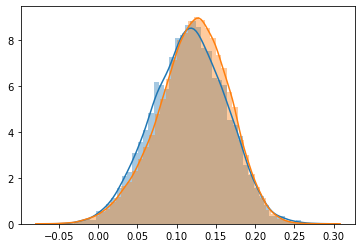

In [ ]:
import seaborn as sns
sns.distplot(zero_vals)
sns.distplot(nonzero_vals)

In [ ]:
np.mean(zero_vals)
np.mean(nonzero_vals)

0.12055423246639663